In [1]:
import pandas as pd
import itertools
import hashlib
from tqdm import tqdm
from collections import defaultdict

In [2]:
df = pd.read_csv('../files/atchley.csv')
df.set_index('amino.acid', inplace=True)
atchley_features = df.to_dict(orient='index')
for key, value in atchley_features.items():
    atchley_features[key] = list(value.values())

In [5]:
def generate_mutations(sequence, max_mutations):
    yield sequence, 0, ""
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    for i in range(1, max_mutations + 1):
        for positions in itertools.combinations(range(len(sequence)), i):
            for new_aas in itertools.product(aa, repeat=i):
                mutated_sequence = list(sequence)
                for pos, new_aa in zip(positions, new_aas):
                    mutated_sequence[pos] = new_aa
                mutated_sequence = "".join(mutated_sequence)
                if mutated_sequence != sequence:
                    yield mutated_sequence, 0, sequence

In [6]:
def truncate_sequences(sequences, right, left):
    middle_strings = []
    for sequence in tqdm(sequences, "truncating sequences"):
        start_index = max(0, len(sequence)//2 - left)
        end_index = min(len(sequence)//2 + right, len(sequence))
        middle_strings.append(sequence[start_index:end_index])
    return middle_strings

In [7]:
sequence_map = {}

# 1000 sequences
sequences_csv = '../files/forchen_F_26L.csv'
sequences_header = "cdr3_amino_acid"

# # 40K sequences
# sequences_csv = '../files/for_chen_B.csv'
# sequences_header = "CDR3.aa"

# # 1M sequences
# sequences_csv = "../random_sequences.csv"
# sequences_header = "sequences"

mutations_df = pd.DataFrame(columns=['mutation','mutation_hash' 'original'])

sequences_df = pd.read_csv(sequences_csv)
sequences_set = set(sequences_df[sequences_header].unique())

In [8]:
sequences_set = truncate_sequences(sequences_set, 4, 4)

truncating sequences: 100%|██████████| 1178/1178 [00:00<00:00, 1280023.35it/s]


In [21]:
max_mutations = 3

mutations_lst = []

for seq in tqdm(sequences_set, desc="generating mutations"):
    mutations_lst.extend(generate_mutations(seq, max_mutations))

generating mutations:   8%|▊         | 99/1178 [00:43<14:17,  1.26it/s]

: 

In [10]:
mutations_df = pd.DataFrame(mutations_lst, columns=['mut', 'mut_hash', 'org'])

In [11]:
distances_csv = "../distance_matrix.csv"
distances_df = pd.read_csv(distances_csv, index_col=0)
distances_dict = {(aa1, aa2): distances_df.loc[aa1, aa2] for aa1 in distances_df.index for aa2 in distances_df.columns}

In [12]:
couples = defaultdict(list)
mask_org_empty = mutations_df['org'] == ""
duplicates_with_empty_org = mutations_df[mutations_df.duplicated(['mut'], keep=False) & mask_org_empty]
filtered_df = mutations_df[mutations_df['mut'].isin(duplicates_with_empty_org['mut'])]

In [13]:

for index, row in tqdm(list(filtered_df.iterrows()), "finding duplicates"):
    if row["org"] != "":
        mut = row["mut"]
        seq = row["org"]
        couples[seq].append([mut, sum(distances_dict[(aa1, aa2)] for aa1, aa2 in zip(seq, mut))])


finding duplicates: 100%|██████████| 1197/1197 [00:00<00:00, 75884.31it/s]


In [14]:
couples = {key: sorted(value, key=lambda x: x[1]) for key, value in couples.items()}

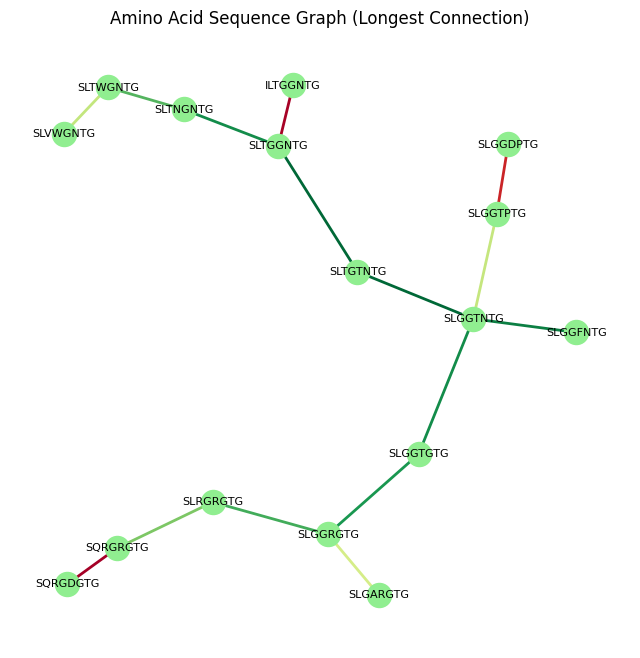

In [ ]:
from json import dump 
output_file = "couples.json"
with open(output_file, "w") as f:
    dump(couples, f)

In [5]:
def expand_sequences(mapper, couples):
    # Initialize an empty dictionary for the full couples
    couples_full = {}

    # Iterate over each key, value pair in the couples dictionary
    for short_seq, neighbors in couples.items():
        # Get the original sequences for the current short sequence
        original_seqs = mapper.get(short_seq, [])
        
        # Iterate over each original sequence
        for original_seq in original_seqs:
            # Initialize the neighbors list for the current original sequence
            if original_seq not in couples_full:
                couples_full[original_seq] = []
            
            # Iterate over each neighbor in the neighbors list
            for neighbor, distance in neighbors:
                # Get the original sequences for the neighbor
                neighbor_original_seqs = mapper.get(neighbor, [])
                
                # Add each original neighbor sequence with the same distance
                for neighbor_original_seq in neighbor_original_seqs:
                    couples_full[original_seq].append([neighbor_original_seq, distance])

    return couples_full

# Example usage
mapper = {"A":["AA", "AAA"], "BA":["BABA", "BAA"], "C":["CC"]}
couples = {"A":[["BA", 1], ["C", 2]], "C":[["BA", 3]]}

couples_full = expand_sequences(mapper, couples)
print(couples_full)


{'AA': [['BABA', 1], ['BAA', 1], ['CC', 2]], 'AAA': [['BABA', 1], ['BAA', 1], ['CC', 2]], 'CC': [['BABA', 3], ['BAA', 3]]}


In [ ]:
{'AA': [['BABA', 1], ['BAA', 1], ['CC', 2]], 
 'AAA': [['BABA', 1], ['BAA', 1], ['CC', 2]], 
 'CC': [['BABA', 3], ['BAA', 3]]}



In [6]:

# Helper function to perform DFS and label clusters
def dfs(sequence, cluster_id, visited, clusters, max_neighbors):
    stack = [sequence]
    while stack:
        current = stack.pop()
        if current not in visited:
            visited.add(current)
            clusters[current] = cluster_id
            neighbors = couples_full.get(current, [])
            neighbors.sort(key=lambda x: x[1])
            for neighbor, _ in neighbors[:max_neighbors]:
                if neighbor not in visited:
                    stack.append(neighbor)

# Main function to cluster sequences
def cluster_sequences(couples_full, max_neighbors):
    visited = set()
    clusters = {}
    cluster_id = 0
    
    for sequence in couples_full.keys():
        if sequence not in visited:
            dfs(sequence, cluster_id, visited, clusters, max_neighbors)
            cluster_id += 1
            
    return clusters

# Set the maximum number of neighbors
max_neighbors = 2  # Adjust this value as needed

# Get the clusters
cluster_dict = cluster_sequences(couples_full, max_neighbors)

# Print the cluster dictionary
print(cluster_dict)

{'AA': 0, 'BAA': 0, 'BABA': 0, 'AAA': 1, 'CC': 2}


In [9]:
import json
with open("../output_files/tests/cdr3_amino_acid/test.json") as json_file:
    couples = json.load(json_file)

In [10]:
max_neighbors = 1

mapper = {}
curr_clusters = 0
for sequence, neighbors in couples.items():
    update = True
    to_add = []
    to_add.append(sequence)
    to_add.extend([neighbor[0] for neighbor in neighbors[:max_neighbors]])
    # print(sequence, neighbors[:max_neighbors], to_add)

    cluster = curr_clusters

    for seq in to_add:
        if seq == "LGGTGGSY":
            print()
        if seq in mapper.keys():
            cluster = mapper[seq]
            update = False
            break

    for seq in to_add:
        mapper[seq] = cluster
    if update:
        curr_clusters += 1

mapper = dict(sorted(mapper.items(), key=lambda item: item[1]))
mapper

{'KARTGTPH': 0,
 'QATTGTPY': 0,
 'LGQGADTG': 1,
 'EDQGAFTG': 1,
 'LGQDTYTG': 1,
 'LPSGGDTG': 1,
 'LDMGRDTG': 1,
 'PGKGSMNT': 2,
 'PFRGYMNT': 2,
 'EFSGGGIY': 3,
 'VFSGTGGY': 3,
 'LIAGTGGY': 3,
 'QISGTGGD': 3,
 'LNVGTGNY': 3,
 'SPGGSNTG': 4,
 'SSGGSNTG': 4,
 'DAGHSNTG': 4,
 'SPLGQLTG': 4,
 'PPGRSNTG': 4,
 'SPTGANTG': 4,
 'QTGGLMNT': 5,
 'PPLGLMNT': 5,
 'QDPTLMNT': 5,
 'QGGGERNY': 6,
 'QGGGRGNQ': 6,
 'HRGGYGNQ': 6,
 'QGTARGNQ': 6,
 'RGTARGGN': 6,
 'DQTGVGTD': 7,
 'DSTGRGTD': 7,
 'QETTRGTD': 7,
 'LWTGRGYD': 7,
 'ETGVVGGN': 8,
 'GTGVFSGN': 8,
 'HTGADSGN': 8,
 'LEGARSGN': 8,
 'VGGGGFTD': 9,
 'VGEGGHTD': 9,
 'PGGGGAKD': 9,
 'PNWGGHTD': 9,
 'VEERGFTD': 9,
 'VGSRGATD': 9,
 'GTGERYNS': 10,
 'LKGSSYNS': 10,
 'LDRSSYNS': 10,
 'DSHGFSYN': 11,
 'DSSGGEYN': 11,
 'DLLSGNTD': 12,
 'DLSQGFTD': 12,
 'PTSGGAGK': 13,
 'LVSGGAGE': 13,
 'LGSGGAIH': 13,
 'WGSGGRDY': 14,
 'PPSGGRDY': 14,
 'PDSGGPYY': 14,
 'YSIGGALY': 15,
 'YSIGGGHS': 15,
 'YQRGGGYS': 15,
 'YSGQGAWH': 16,
 'YAGQGAYT': 16,
 'YSGQGKDS': 16,
 'PQG